In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import random
from random import randint
import time

In [2]:
DAYS = pd.Timedelta(days=1)

In [3]:
FILE_NAME = "PQ2MON - Orders - Weeks -1 to -109 (1).xls.xlsx"
DF = pd.read_excel(FILE_NAME)
DF.head(5)

,Client Grouping1,Customer Group,Requested Mode,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Lane ID - City to City,Start Date,Completion Date,Order #,Avg. Weekly Frequency
0,Corporate,3M Canada Company,ROAD,Standard,DRY,ON2TOR,PQ2S,"MILTON,ON/ to DRUMMONDVILLE,PQ/",2019-04-16,2019-04-18,3790088,0
1,Corporate,3M Canada Company,ROAD,Standard,DRY,ON2TOR,PQ2S,"MILTON,ON/ to DRUMMONDVILLE,PQ/",2019-05-07,2019-05-09,3810953,0
2,Corporate,3M Canada Company,ROAD,Standard,DRY,ON2TOR,PQ2S,"MILTON,ON/ to DRUMMONDVILLE,PQ/",2019-06-07,2019-06-10,3841144,0
3,Corporate,3M Canada Company,ROAD,Standard,DRY,ON2TOR,PQ2S,"MILTON,ON/ to DRUMMONDVILLE,PQ/",2019-07-09,2019-07-11,3869973,0
4,Corporate,3M Canada Company,ROAD,Standard,DRY,PQ2MON,USMWIA,"STE THERESE,PQ/TE to PRAIRIE DU CHIEN,WI/",2020-02-26,2020-03-02,4066936,0


In [4]:
# Clean the irrelevant columns, only keeping the rows that has PQ data
# internal are orders that starts and completes within the PQ region itself.
# external are orders that goes from anyhwere in PQ to other region and vice versa
def clean_df(df,drop=None,region='PQ',order_type=None):
    if drop == None: drop = ["Customer Group","Requested Mode","Order #","Avg. Weekly Frequency","Lane ID - City to City","Client Grouping1"]
    
    df_PQ = df[df['Shipper Region3'].str.startswith(region)|df['Consignee Region3'].str.contains(region)].drop(columns=drop)
    df_PQ.loc[:,'Shipper Region3'].fillna("UNKNOWN",inplace=True)
    df_PQ.loc[:,'Consignee Region3'].fillna("UNKNOWN",inplace=True)
    df_PQ_int = df_PQ[df_PQ['Shipper Region3'].str.startswith(region) & df_PQ["Consignee Region3"].str.contains(region)]
    df_PQ_ext = df_PQ.drop(index = df_PQ_int.index)
    
    if order_type == "internal": return df_PQ_int
    elif order_type == "external": return df_PQ_ext
    else: return df_PQ

In [5]:
DF_CLEAN = clean_df(DF)
DF_CLEAN.head(5)

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
0,Standard,DRY,ON2TOR,PQ2S,2019-04-16,2019-04-18
1,Standard,DRY,ON2TOR,PQ2S,2019-05-07,2019-05-09
2,Standard,DRY,ON2TOR,PQ2S,2019-06-07,2019-06-10
3,Standard,DRY,ON2TOR,PQ2S,2019-07-09,2019-07-11
4,Standard,DRY,PQ2MON,USMWIA,2020-02-26,2020-03-02


In [6]:
# Get the counts for a schedule, such as inbound and out bound figures. Also calculates the imbalance levels
def get_df_count(df,start_date=None,end_date=None,trailer_class=None,fill_missing=False,region='PQ'):
    start_date = get_earliest(df) if start_date == None else start_date
    end_date   = get_latest(df)   if end_date == None else end_date
    cond_tr_class = True if trailer_class == None else (df['Requested Trailer Class'] == trailer_class)
    cond_out = df['Shipper Region3'].str.startswith(region)
    cond_in  = df['Consignee Region3'].str.startswith(region)
    
    df_out = df[cond_out & cond_tr_class]['Start Date'].value_counts().sort_index(axis=0)
    df_in  = df[cond_in & cond_tr_class]['Completion Date'].value_counts().sort_index(axis=0)
    
    df_count = pd.concat([df_out, df_in],axis=1).fillna(0, downcast='infer').rename(columns={"Start Date": "Outbound", "Completion Date": "Inbound"})
    if fill_missing and start_date and end_date:
        df_count = df_count.join(pd.DataFrame(index=get_dates(start_date,end_date)),how='outer').fillna(0) 
    df_count["Imbalance"]  = df_count["Inbound"] - df_count["Outbound"]
    df_count["cImbalance"] = df_count["Imbalance"].cumsum()
    return df_count.loc[start_date:end_date].astype('int64')


def get_dates(start_date,end_date):
    if type(start_date) == pd.Timestamp and type(end_date) == pd.Timestamp:
        return [start_date + i*DAYS for i in range(int((end_date-start_date).days+1))]
    else: return []

def get_earliest(df,col=["Start Date","Completion Date"],region='PQ'):
    region = '' if region == 'any' else region
    if col == ["Start Date","Completion Date"]:
        return df.loc[:,col].min().min()
    elif col == 'Start Date':
        cond = df['Shipper Region3'].str.startswith(region) 
        return df[cond].loc[:,col].min()
    elif col == 'Completion Date':
        cond = df['Consignee Region3'].str.startswith(region) 
        return df[cond].loc[:,col].min()
    
def get_latest(df,col=["Start Date","Completion Date"],region='PQ'):
    region = '' if region == 'any' else region
    if col == ["Start Date","Completion Date"]:
        return df.loc[:,col].max().max()
    elif col == 'Start Date':
        cond = df['Shipper Region3'].str.startswith(region) 
        return df[cond].loc[:,col].max()
    elif col == 'Completion Date':
        cond = df['Consignee Region3'].str.startswith(region) 
        return df[cond].loc[:,col].max()    

In [7]:
#Demo
start_date = pd.Timestamp(2019,3,13,0)
end_date = pd.Timestamp(2019,3,19,0)

# df_count = get_df_count(DF_CLEAN,start_date,end_date)
df_count = get_df_count(DF_CLEAN,start_date,end_date,fill_missing=True)
df_count

,Outbound,Inbound,Imbalance,cImbalance
2019-03-13,1,0,-1,-1
2019-03-14,0,0,0,-1
2019-03-15,0,0,0,-1
2019-03-16,0,0,0,-1
2019-03-17,0,0,0,-1
2019-03-18,0,0,0,-1
2019-03-19,2,0,-2,-3


In [22]:
# Get all the orders that start and/or completes on a specific day
def get_df_day(df,date,col=['Start Date','Completion Date'],trailer_class=None,region='PQ'):
    cond_tr_class = True if trailer_class == None else (df['Requested Trailer Class'] == trailer_class)        
    cond_out = df['Shipper Region3'].str.startswith(region)
    cond_in  = df['Consignee Region3'].str.startswith(region)
    cond_start_date = df['Start Date'] == date
    cond_compl_date = df['Completion Date'] == date
    
    if   col == 'Start Date':      return df[cond_out & cond_start_date & cond_tr_class]
    elif col == 'Completion Date': return df[cond_in & cond_compl_date & cond_tr_class]
    elif col == ['Start Date','Completion Date']: 
        return df[(cond_out & cond_start_date & cond_tr_class)|(cond_in & cond_compl_date & cond_tr_class)]

# Get all orders that starts and/or completes in a specific time span
def get_df_span(df,start_date=None,end_date=None,col=['Start Date','Completion Date'],trailer_class=None,region='PQ'):
    start_date = get_earliest(df) if start_date == None else start_date
    end_date = get_latest(df) if end_date == None else end_date
    cond_tr_class = True if trailer_class == None else (df['Requested Trailer Class'] == trailer_class)   
    cond_start_date = (df["Start Date"] >= start_date) & (df["Start Date"] <= end_date)
    cond_compl_date = (df["Completion Date"] >= start_date) & (df["Completion Date"] <= end_date)
    cond_out = df['Shipper Region3'].str.startswith(region) 
    cond_in = df['Consignee Region3'].str.startswith(region) 
    
    if   col == 'Start Date':      return df[cond_out & cond_start_date & cond_tr_class]
    elif col == 'Completion Date': return df[cond_in & cond_compl_date & cond_tr_class]
    elif col == ['Start Date','Completion Date']: 
        return df[(cond_out & cond_start_date & cond_tr_class)|(cond_in & cond_compl_date & cond_tr_class)]

In [23]:
df = DF_CLEAN
date1 = pd.Timestamp(2020,1,1,0)
date2 = pd.Timestamp(2020,1,7,0)

get_df_span(df,date1,date2)
# get_df_day(DF_CLEAN,pd.Timestamp(2020,1,15,0),region="US")

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
15,Standard,DRY,PQ2OTT,PQ2MON,2019-12-30,2020-01-03
58,Standard,DRY,USMNMI,PQ2S,2020-01-03,2020-01-07
619,Standard,DRY,PQ2MON,USMEON,2020-01-06,2020-01-08
640,Standard,DRY,PQ2MON,USMEON,2020-01-03,2020-01-06
650,Standard,DRY,PQ2MON,USMEON,2020-01-06,2020-01-08
...,...,...,...,...,...,...
22182,Expedited,DRY,PQ2MON,ABNEDM,2020-01-04,2020-01-06
22183,Expedited,DRY,PQ2MON,ABNEDM,2020-01-06,2020-01-09
22821,Expedited,HEATER,PQ2MON,ABSCAL,2020-01-07,2020-01-09
22917,Expedited,HEATER,PQ2MON,MB2WIN,2020-01-03,2020-01-05


In [24]:
# Get the bound (earliest/latest) dates in between which an order have to start and complete.
# By default the assumption would be that the order must start in between 14 days prior to 
# originally scheduled all the way to 0 days before; and must completes within 1 day prior to 1 day after
# originally scheduled.
# Because of this, we based the completion date on the date in the ORIGINAL schedule (i.e DF_CLEAN)
def get_bound_dates(index):
    df = DF_CLEAN
    compl_date = df.loc[index,'Completion Date']
    e_start,l_start = compl_date - get_max_duration(index), compl_date - get_min_duration(index)
    e_compl,l_compl = compl_date - 1*DAYS, compl_date + 1*DAYS
    return {"e_start":e_start,"l_start":l_start,"e_compl":e_compl,"l_compl":l_compl}

# Checks if an order violates any boundaries, especially after rescheduled
def check_bound_violations(df,index,check_start=True,check_compl=True):
    start = df.loc[index,'Start Date'] 
    compl = df.loc[index,'Completion Date']
    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
    start_viol = check_start and (start < e_start or start > l_start)
    compl_viol = check_compl and (compl < e_compl or compl > l_compl)
    return start_viol or compl_viol

# Get orders that have the same values in columns in col
# Used mostly to determine the shortest/longest expected time for order of the same type
def get_df_similar_orders(df,index,col=["Priority","Requested Trailer Class","Shipper Region3","Consignee Region3"]):
    order = df.loc[index,col]
    df_dup = df.loc[:,col]
    df_dup = df_dup[df_dup == order].dropna()
    return df.loc[df_dup.index,:]

def get_min_duration(index):
    df = DF_CLEAN
    df1 = get_df_similar_orders(df,index)
    return min(df1["Completion Date"]-df1["Start Date"])

def get_max_duration(index):
    df = DF_CLEAN
    df1 = get_df_similar_orders(df,index)
    return max(df1["Completion Date"]-df1["Start Date"])

In [25]:
get_max_duration(55)

Timedelta('14 days 00:00:00')

In [26]:
# Demo
df = DF_CLEAN
index = df.index[5]

print(df.loc[index,'Start Date':'Completion Date'],'\n')
print("Violation: ",check_bound_violations(df,index))
get_bound_dates(index)

Start Date         2020-04-08 00:00:00
Completion Date    2020-04-10 00:00:00
Name: 5, dtype: object 

Violation:  False


{'e_start': Timestamp('2020-04-04 00:00:00'),
 'l_start': Timestamp('2020-04-08 00:00:00'),
 'e_compl': Timestamp('2020-04-09 00:00:00'),
 'l_compl': Timestamp('2020-04-11 00:00:00')}

In [27]:
# Get only orders from day1 that *can be moved* to day2
def get_df_movable_only(df,col,day1,day2):
    df1 = get_df_day(df,day1,col)
    mov = [] 
    for index in df1.index:
        if (movable(df1,index,col,day2)):
            mov.append(index)
    return df1.loc[mov]

# Can we move the Start/Completion Date of the item at index to this day?
# Condition being, the start date can not be too late compared to the original schedule, or later than the completion date)
# Condition being, the completion date can not be too early or too late compared to the original schedule 
# (see get_bound_dates() for more )
def movable(df,index,col,day):
    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
    compl_date = df.loc[index,"Completion Date"]
    if col == 'Start Date': return day <= l_start and day <= compl_date #or day >= e_start
    elif col == 'Completion Date': return day >= e_compl and day <= l_compl

In [28]:
date1 = pd.Timestamp(2020,1,4,0)
date2 = pd.Timestamp(2020,1,7,0)
get_df_movable_only(df,'Start Date',date1,date2)

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
16970,Expedited,DRY,PQ2MON,ABSCAL,2020-01-04,2020-01-07
19505,Standard,REEFER,PQ2MON,ABNEDM,2020-01-04,2020-01-10
19689,Standard,REEFER,PQ2MON,BC2VAN,2020-01-04,2020-01-10


In [45]:
# Actually reschedule an order in the scheduling table (by overwriting the date in column col)
# Returns the modified schedule and the updated counts
def move(df,index,new_day,col='Start Date'):
    df_resched = df.copy()
    df_resched.loc[index,col] = new_day
    return df_resched


# Try to move a number of orders that starts on day1 to day2, or that completes on day1 to day2
# Return the modified the df, and the ACTUAL number of orders moved.
# This is because in reality, constraints apply and many times there are not
# enough available orders to satisfy the request
def try_move_orders(df,col,day1,day2,num_orders=None,verbose=False):
    df1 = df.copy()
    df_movable_only = get_df_movable_only(df1,col,day1,day2) # Get ONLY orders from day1 that *can be moved* to day2
    
    if col == "Start Date":
        if day2 > day1:
        # If we are moving the Start date forward
            # Pick furthest completion dates first (longest duration)
            df_movable_only.sort_values(by="Completion Date",ascending=False,inplace=True) 
        elif day1 > day2:
        # If we are moving the Start date back
            # Pick nearest completion dates first (shortest duration)
            df_movable_only.sort_values(by="Completion Date",ascending=True,inplace=True) 
    elif col == "Completion Date":
        if day2 > day1:
        # If we are moving the Completion date forward
            # Pick nearest start dates first (shortest duration)
            df_movable_only.sort_values(by="Start Date",ascending=True,inplace=True) 
        elif day1 > day2:
        # If we are moving the Completion date back
            # Pick furthest start dates first (longest duration)
            df_movable_only.sort_values(by="Start Date",ascending=False,inplace=True) 

    if num_orders == None or num_orders < 0: 
        num_orders = len(df_movable_only)
    df_orders = df_movable_only[:int(num_orders)] # Get just enough requested orders from day1 that can be moved to day2
    
    for index in df_orders.index:
        assert(df1.loc[index,col] == day1)
        df1 = move(df1,index,day2,col) # Finally move such orders to day2
        
    if verbose: 
        print("- Moved {}/{} requested {}s from Day {} to Day {}".format(len(df_orders),num_orders,col,day1,day2))
        print(get_df_count(df1).loc[[day1,day2]])
    return df1, len(df_orders)

In [46]:
# Attempt to move orders between day1 and day2 to achieve a certain balance value
# By default, it would use the mean imbalance level of both days as the goal
def balance(df,day1,day2,bal_val=None,verbose=False):
    df1 = df.copy()
    df_count = get_df_count(df1,day1,day2,fill_missing=True)
    
    if verbose: 
        print("\nDays: {} - {}".format(day1,day2))
        print("Before:\n",df_count.loc[[day1,day2]])
    
    if bal_val == None: bal_val = int(np.average(df_count.loc[[day1,day2],"Imbalance"]))
    out1,in1 = df_count.loc[day1,["Outbound","Inbound"]]
    out2,in2 = df_count.loc[day2,["Outbound","Inbound"]]
    d_bal = bal_val - df_count.loc[day1,"Imbalance"]
    d_out,d_in1,d_in2= 0,0,0
    
    if d_bal > 0:
        if (in1 >= in2 and out1 >= out2):
        # If traffic is heavier today, we prioritize reducing outbound traffic
            # We try to defer as many outbound orders to tomorrow as possible
            # If it's not enough then we make up by taking in tomorrow's inbound orders
            df1,d_out = try_move_orders(df1,"Start Date",day1,day2,d_bal,verbose) 
            df1,d_in1 = try_move_orders(df1,"Completion Date",day2,day1,d_bal-d_out,verbose) 
         
        elif (in1 <= in2 and out1 <= out2): 
        # If traffic is less today, we prioritize increasing inbound traffic 
            # We try to take in as many inbound orders from tomorrow as possible
            # If it's not enough then we make up by deferring the outbound order til tomorrow
            df1,d_in1 = try_move_orders(df1,"Completion Date",day2,day1,d_bal,verbose) 
            df1,d_out = try_move_orders(df1,"Start Date",day1,day2,d_bal-d_in1,verbose) 

        else:
        # If inbound and outbound traffic comparison is mixed, we pick half each type to even everything out
            # We try achieve 1/2 of d_bal by taking in tomorrow inbound orders
            # Then try achieve the rest of d_bal by deferring outbound orders 
            # Go back to step 1 and try to take in more tomorrow inbound orders just in case d_bal is not achieved  
            df1,d_in1 = try_move_orders(df1,"Completion Date",day2,day1,d_bal//2,verbose) 
            df1,d_out = try_move_orders(df1,"Start Date",day1,day2,d_bal-d_in1,verbose) 
            df1,d_in2 = try_move_orders(df1,"Completion Date",day2,day1,d_bal-(d_in1+d_out),verbose) 

    elif d_bal < 0:  # If we need to reduce incoming traffic/ increase outbound traffic
        d_bal = abs(d_bal)
        if (in1 >= in2 and out1 >= out2): 
        # If traffic is heavier today, we prioritize reducing inbound traffic
            # We try to defer as many inbound orders to tomorrow as possible
            # If it's not enough then we make up by taking in the outbound order from tomorrow
            df1,d_in1 = try_move_orders(df1,"Completion Date",day1,day2,d_bal,verbose) 
            df1,d_out = try_move_orders(df1,"Start Date",day2,day1,d_bal-d_in1,verbose) 

        elif (in1 <= in2 and out1 <= out2): 
        # If traffic is less today, we prioritize increasing outbound traffic 
            # We try to take in as many outbound orders from tomorrow as possible
            # If it's not enough then we make up by deferring some inbound truck to tomorrow
            df1,d_out = try_move_orders(df1,"Start Date",day2,day1,d_bal,verbose) 
            df1,d_in1 = try_move_orders(df1,"Completion Date",day1,day2,d_bal-d_out,verbose) 

        else: 
        # If inbound and outbound traffic comparison is mixed, we pick half each type to even everything out 
            # We try achieve 1/2 of d_bal by deferring inbound orders to tomorrow
            # Then try achieve the rest of d_bal by taking in tomorrow outbound orders 
            # Go back to step 1 and try to defer more inbound orders to tomorrow just in case d_bal is not achieved
            df1,d_in1 = try_move_orders(df1,"Completion Date",day1,day2,d_bal//2,verbose) 
            df1,d_out = try_move_orders(df1,"Start Date",day2,day1,d_bal-d_in1,verbose) 
            df1,d_in2 = try_move_orders(df1,"Completion Date",day1,day2,d_bal-(d_in1+d_out),verbose) 
        # Invert the number to get the right statistics
        d_bal *= -1
        d_in1 *= -1
        d_in2 *= -1
        d_out*=-1
    
    d_out*=-1
    
    df_count = get_df_count(df1,day1,day2,fill_missing=True)
    if verbose:
        print("d_bal =",d_bal,": d_out =", d_out,"d_in =",d_in1+d_in2,"(bal_val =",bal_val,")")
        print("After:\n",df_count.loc[[day1,day2]],'\n')

    return df1
        

In [47]:
# Demo balance()
date = pd.Timestamp(2020,12,24,0)
df = get_df_span(DF_CLEAN,date,date+14*DAYS)
df_count = get_df_count(df)
print(df_count)
day1 = df_count.index[-4]
day2 = df_count.index[-1]

# out1,in1 = df_count.loc[day1,["Inbound","Outbound"]]
# out1,in1
df1 = balance(df,day1,day2,verbose=True)

            Outbound  Inbound  Imbalance  cImbalance
2020-12-22         2        0         -2          -2
2020-12-24        10       16          6           4
2020-12-25         3        6          3           7
2020-12-26         7       11          4          11
2020-12-27        11        6         -5           6
2020-12-28        13       20          7          13
2020-12-29        18       17         -1          12
2020-12-30        21       18         -3           9
2020-12-31        15       23          8          17
2021-01-01         1        2          1          18
2021-01-02        12       10         -2          16
2021-01-03         8        3         -5          11
2021-01-04        20       23          3          14
2021-01-05        23       26          3          17
2021-01-06        18       25          7          24
2021-01-07        15       23          8          32

Days: 2021-01-04 00:00:00 - 2021-01-07 00:00:00
Before:
             Outbound  Inbound  Imbalance 

In [48]:
def local_k_average(df,k=2,verbose=False):
    df_resched = df.copy()
    df_count = get_df_count(df_resched,fill_missing=True)
    dates = df_count.index
    num_days = len(dates)
    for i in range(num_days):
        k = int(min(num_days-i,k)) # Address the last k-1 problem. (More at the end) 
        local_queue = list(range(i,i+k))
        while (len(local_queue)>=2):
            day1 = dates[local_queue[0]]
            day2 = dates[local_queue[1]]
            last = dates[local_queue[-1]]
            df_count = get_df_count(df_resched,day1,last,fill_missing=True)
            bal_val = int(np.average(df_count.loc[day1:last,"Imbalance"]))
            df_resched = balance(df_resched,day1,day2,bal_val,verbose)
            local_queue.pop(0)
    return df_resched

In [49]:
start_date = pd.Timestamp(2020,1,1,0)
end_date = pd.Timestamp(2020,1,31,0)
df = get_df_span(DF_CLEAN,start_date,end_date)
df_time = pd.DataFrame(index=[2,3,4,5,6,7,10,14])

for k in df_time.index:
    #    <<---- Begin timer ---->>
    start_time = time.time()
    #    <<--- Begin execution ->>
    
    df_resched = local_k_average(df,k,verbose=True)
    
    #    <<--- End execution --->>
    end_time = time.time()
    #    <<----- End timer ----->>
    
    # Post execution
    df_resched.to_csv("dfs/2020/"+"k_"+str(k))
    df_time.loc[k,"Time (s)"] = end_time-start_time
    print("k = {} : {:.6f}".format(k,df_time.loc[k,"Time (s)"]))
    
    
df_time


Days: 2019-11-22 00:00:00 - 2019-11-23 00:00:00
Before:
             Outbound  Inbound  Imbalance  cImbalance
2019-11-22         0        0          0           0
2019-11-23         0        0          0           0
d_bal = 0 : d_out = 0 d_in = 0 (bal_val = 0 )
After:
             Outbound  Inbound  Imbalance  cImbalance
2019-11-22         0        0          0           0
2019-11-23         0        0          0           0 


Days: 2019-11-23 00:00:00 - 2019-11-24 00:00:00
Before:
             Outbound  Inbound  Imbalance  cImbalance
2019-11-23         0        0          0           0
2019-11-24         0        0          0           0
d_bal = 0 : d_out = 0 d_in = 0 (bal_val = 0 )
After:
             Outbound  Inbound  Imbalance  cImbalance
2019-11-23         0        0          0           0
2019-11-24         0        0          0           0 


Days: 2019-11-24 00:00:00 - 2019-11-25 00:00:00
Before:
             Outbound  Inbound  Imbalance  cImbalance
2019-11-24         0     

d_bal = 0 : d_out = 0 d_in = 0 (bal_val = 0 )
After:
             Outbound  Inbound  Imbalance  cImbalance
2019-12-12         0        0          0           0
2019-12-13         0        0          0           0 


Days: 2019-12-13 00:00:00 - 2019-12-14 00:00:00
Before:
             Outbound  Inbound  Imbalance  cImbalance
2019-12-13         0        0          0           0
2019-12-14         0        0          0           0
d_bal = 0 : d_out = 0 d_in = 0 (bal_val = 0 )
After:
             Outbound  Inbound  Imbalance  cImbalance
2019-12-13         0        0          0           0
2019-12-14         0        0          0           0 


Days: 2019-12-14 00:00:00 - 2019-12-15 00:00:00
Before:
             Outbound  Inbound  Imbalance  cImbalance
2019-12-14         0        0          0           0
2019-12-15         0        0          0           0
d_bal = 0 : d_out = 0 d_in = 0 (bal_val = 0 )
After:
             Outbound  Inbound  Imbalance  cImbalance
2019-12-14         0        0

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: DatetimeIndex(['2019-12-30'], dtype='datetime64[ns]', freq=None). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [50]:
df_count = get_df_count(DF_CLEAN)
df_count

,Outbound,Inbound,Imbalance,cImbalance
2019-03-13,1,0,-1,-1
2019-03-19,2,0,-2,-3
2019-03-20,2,0,-2,-5
2019-03-21,1,0,-1,-6
2019-03-22,12,0,-12,-18
...,...,...,...,...
2021-04-20,21,20,-1,251
2021-04-21,12,25,13,264
2021-04-22,10,30,20,284
2021-04-23,11,24,13,297


In [53]:
day = df_count.index[0]
day1 = df_count.index[1]

day
df_count.loc[[day,day+1*DAYS]]


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: DatetimeIndex(['2019-03-14'], dtype='datetime64[ns]', freq=None). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [54]:
df =DF_CLEAN
df["Requested Trailer Class"].value_counts()

DRY         15954
REEFER       6109
HEATER        985
M-REEFER       26
Name: Requested Trailer Class, dtype: int64

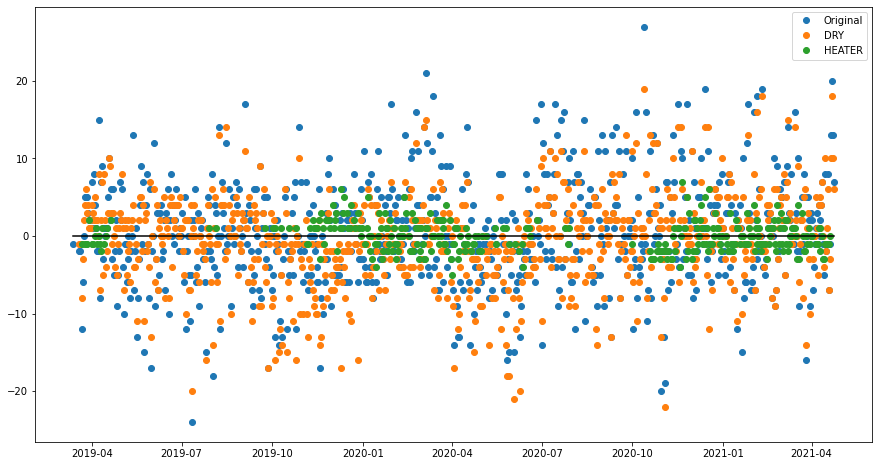

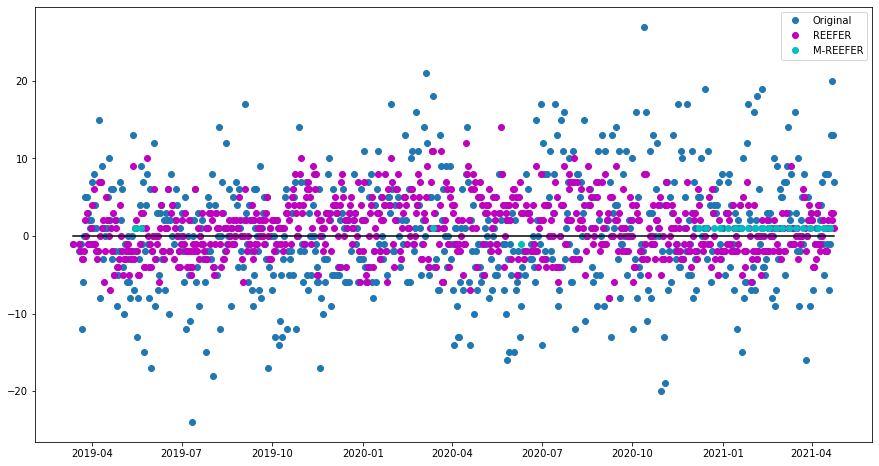

In [55]:
df_count = get_df_count(df)
start_date = min(df_count.index)
end_date = max(df_count.index)

df_count_D = get_df_count(df,trailer_class='DRY')
df_count_H = get_df_count(df,trailer_class='HEATER')
df_count_R = get_df_count(df,trailer_class='REEFER')
df_count_M = get_df_count(df,trailer_class='M-REEFER')


plt.figure(figsize=(15,8))
plt.plot(df_count["Imbalance"],'o',label='Original',linewidth=2)
plt.plot(df_count_D["Imbalance"],'o',label='DRY',linewidth=2)
plt.plot(df_count_H["Imbalance"],'o',label='HEATER',linewidth=2)
plt.plot([start_date,end_date],[0,0],'k-')
plt.legend()
plt.show()

plt.figure(figsize=(15,8))
plt.plot(df_count["Imbalance"],'o',label='Original',linewidth=2)
plt.plot(df_count_R["Imbalance"],'mo',label='REEFER',linewidth=2)
plt.plot(df_count_M["Imbalance"],'co',label='M-REEFER',linewidth=2)
plt.plot([start_date,end_date],[0,0],'k-')
plt.legend()
plt.show()